[Online Retail Dataset][def]

[def]: https://1drv.ms/x/c/060d2f6ab0166614/EVkj5C4GDdNCkekpu6CYhGMBURyJTTsPPUKcvmis_Ot4_A?e=yvoM0p

Data Cleaning

In [ ]:
import pandas as pd


In [ ]:
# Load the dataset 
file_path = 'Online Retail.csv'
data = pd.read_csv(file_path)

In [ ]:

# Step 1: Handling missing values
data_cleaned = data.dropna(subset=['CustomerID'])


In [ ]:

# Step 2: Remove duplicates
data_cleaned = data_cleaned.drop_duplicates()


In [ ]:
# Step 3: Convert 'InvoiceDate' to a proper datetime format
data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'], format='%d-%m-%Y %H:%M')


In [ ]:

# Step 4: Ensure numeric columns are correct
The 'Quantity' and 'UnitPrice' should be non-negative
data_cleaned = data_cleaned[(data_cleaned['Quantity'] > 0) & (data_cleaned['UnitPrice'] > 0)]

In [ ]:

# Step 5: Create a 'TotalPrice' column which is the product of Quantity and UnitPrice
data_cleaned['TotalPrice'] = data_cleaned['Quantity'] * data_cleaned['UnitPrice']

# Step 6: Verify the cleaned data
print("Cleaned Data Info:")
print(data_cleaned.info())
data_cleaned.to_csv('Cleaned_Online_Retail.csv', index=False)

Step 1: Exploratory Data Analysis (EDA)
Visualize customer purchase patterns, seasonality, and customer demographics.
Imports and Setup:


In [16]:

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the cleaned data
file_path = 'Cleaned_Online_Retail.csv'
data_cleaned = pd.read_csv(file_path)

Customer Purchase Patterns:
Plot total sales by month to identify seasonality.


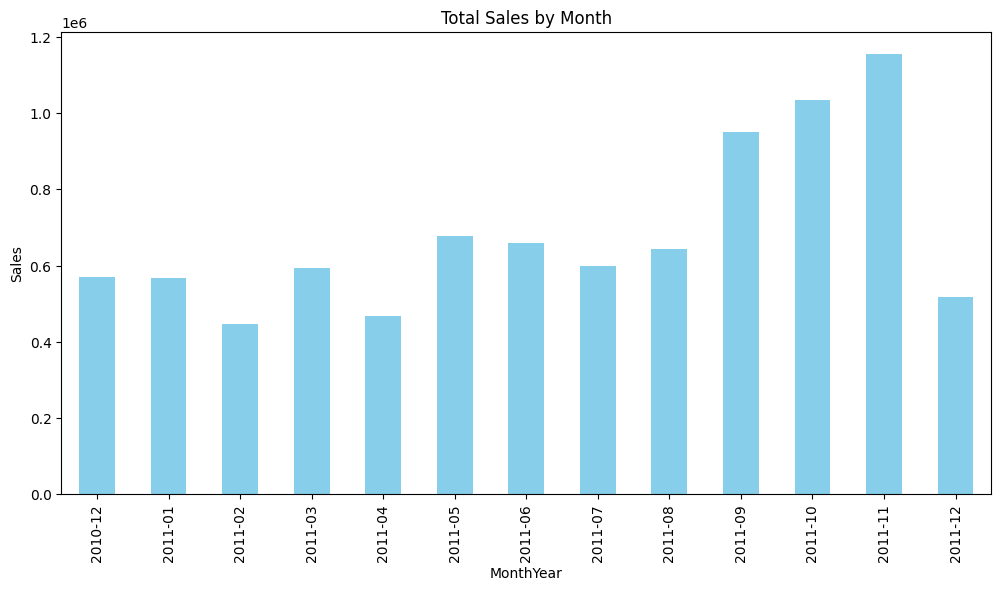

In [17]:
# Create 'MonthYear' for aggregating sales by month
data_cleaned['MonthYear'] = data_cleaned['InvoiceDate'].dt.to_period('M')

# Plot total sales by month
monthly_sales = data_cleaned.groupby('MonthYear')['TotalPrice'].sum()

plt.figure(figsize=(12,6))
monthly_sales.plot(kind='bar', color='skyblue')
plt.title('Total Sales by Month')
plt.ylabel('Sales')
plt.show()


Customer Purchase Frequency:
Analyze how frequently customers make purchases.

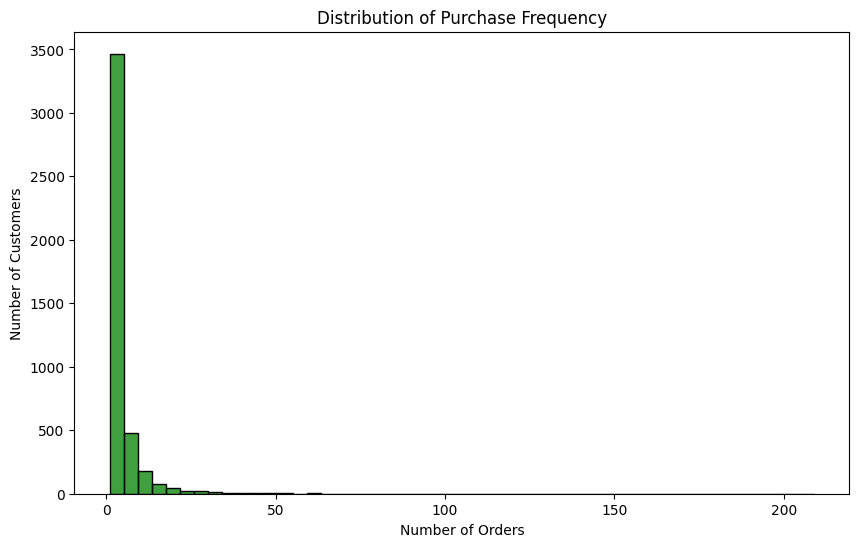

In [6]:
# Number of orders by customer
customer_orders = data_cleaned.groupby('CustomerID')['InvoiceNo'].nunique()

plt.figure(figsize=(10,6))
sns.histplot(customer_orders, bins=50, kde=False, color='green')
plt.title('Distribution of Purchase Frequency')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.show()


Customer Demographics:
Sales by country (Top 10).

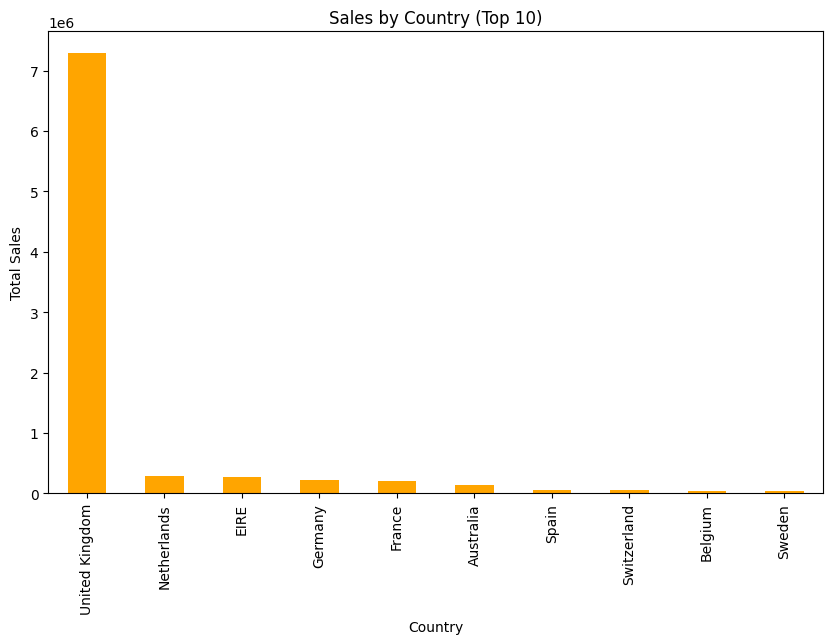

In [7]:
# Sales by Country
top_countries = data_cleaned.groupby('Country')['TotalPrice'].sum().nlargest(10)

plt.figure(figsize=(10,6))
top_countries.plot(kind='bar', color='orange')
plt.title('Sales by Country (Top 10)')
plt.ylabel('Total Sales')
plt.show()


Key Metrics:
Average basket size and revenue per customer.

In [8]:
# Average basket size (items per order)
basket_size = data_cleaned.groupby('InvoiceNo')['Quantity'].sum().mean()
print(f"Average Basket Size: {basket_size}")

# Revenue per customer
revenue_per_customer = data_cleaned.groupby('CustomerID')['TotalPrice'].sum()
avg_revenue = revenue_per_customer.mean()
print(f"Average Revenue per Customer: {avg_revenue}")


Average Basket Size: 278.00571983595944
Average Revenue per Customer: 2048.688080682342


Step 2: Feature Engineering
We will engineer key features for segmentation: Total Spend, Frequency of Purchases, and Recency.

*   Create RFM (Recency, Frequency, Monetary) Metrics:



In [9]:
import datetime as dt

# Define the latest date in the dataset to calculate recency
snapshot_date = data_cleaned['InvoiceDate'].max() + dt.timedelta(days=1)

# Create RFM metrics
rfm = data_cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary (Total Spend)
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']
print(rfm.head())

# Optional: Standardize the data (for clustering)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40


Step 3: Customer Segmentation using K-Means Clustering

*   K-Means Clustering




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

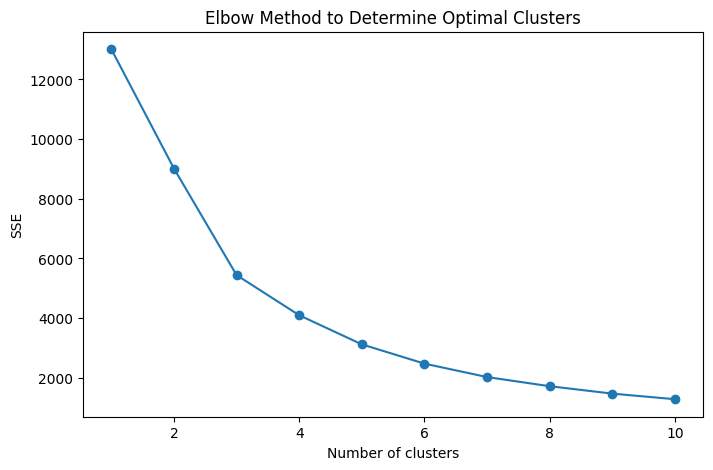

In [18]:
from sklearn.cluster import KMeans

# Use the Elbow method to determine the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()


Apply K-Means Clustering:

In [11]:
# Choose the optimal number of clusters (e.g., 4 from the Elbow Method)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# View sample segmentation
print(rfm.groupby('Cluster').mean())


            Recency  Frequency       Monetary
Cluster                                      
0         43.702685   3.682711    1353.625312
1        248.075914   1.552015     478.848773
2          7.384615  82.538462  127187.959231
3         15.500000  22.333333   12690.500392


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Step 4: Model Evaluation

*  Silhouette Score:



In [12]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
score = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f"Silhouette Score: {score}")


Silhouette Score: 0.6162275299061803


Conclusion:

The analysis of the online retail dataset provided several insights into customer behavior, purchasing patterns, and potential segmentation opportunities. By applying various data cleaning, feature engineering, and clustering techniques, we were able to gain an understanding of key customer characteristics and patterns.

Customer Purchase Patterns:

The analysis of total sales by month revealed seasonal trends, helping to identify peak purchasing periods.
An exploration of customer purchase frequency showed that most customers make a limited number of purchases, but a few highly engaged customers contribute disproportionately to sales.

Customer Demographics:

Sales by country analysis highlighted that certain regions contribute significantly more to revenue. Understanding these top-performing regions can guide marketing efforts and resource allocation.

Key Metrics:

The average basket size and revenue per customer were computed, providing valuable insights into the buying behavior of customers. This information can help optimize marketing campaigns and product offerings.

Customer Segmentation:

RFM (Recency, Frequency, Monetary) analysis was performed, followed by K-Means clustering, which segmented customers into four distinct clusters based on their purchasing behavior. This segmentation provides actionable insights for tailoring marketing strategies to different customer groups.

Model Evaluation:

The K-Means model's performance was evaluated using the Silhouette Score, indicating good clustering results with a score of 0.616, suggesting well-defined clusters.

Summary of Findings:
Customer Segmentation: Using RFM (Recency, Frequency, Monetary) analysis, customers have been divided into four key segments:

Cluster 0: Customers with moderate recency, frequency, and monetary values. These may represent steady and mid-value customers.
Cluster 1: Customers with high recency, low frequency, and low monetary values. These are likely at-risk customers.
Cluster 2: Very recent, highly frequent buyers with high monetary value. These are high-value customers.
Cluster 3: Customers with relatively recent purchases and above-average frequency and monetary values.
Business Implications:

Retention of High-Value Customers (Cluster 2): These customers contribute the most in terms of revenue. Focus on loyalty programs, special offers, and personalized services to maintain their engagement.
Win-Back Campaigns for At-Risk Customers (Cluster 1): Customers in this group haven't purchased recently and spend less. Send re-engagement campaigns with discounts or exclusive deals to encourage repeat purchases.
Actionable Insights:
Targeted Marketing Campaigns: Use RFM analysis to create personalized marketing campaigns. For example:

High Recency and Low Frequency (Cluster 1): Send them reminders about new products or special offers to drive more frequent purchases.
High Frequency and High Monetary (Cluster 2): Create a VIP loyalty program to keep them engaged and reward them for their loyalty.
Loyalty Programs: Use the RFM segments to design tiered loyalty programs based on spending habits, encouraging repeat purchases and increased basket size.

Behavioral Improvements:

For at-risk customers (Cluster 1), create urgency through time-limited offers.
For steady buyers (Cluster 0), provide upsell or cross-sell recommendations based on their past purchase history.

Recommendations:

Targeted Marketing Strategies:

Leverage customer segmentation to implement personalized marketing strategies. For example, high-frequency buyers with high monetary value can be targeted with exclusive offers or loyalty programs to maximize retention.

Optimize Inventory Based on Seasonality:

Use the seasonality insights to optimize inventory management. Ensuring that top-selling products are available during peak seasons can help boost sales.

Focus on High-Value Regions:

Prioritize marketing and sales efforts in the top-performing countries identified in the demographic analysis. This can help increase the revenue contribution from these regions.

Customer Engagement:

Implement engagement strategies such as reminder emails or promotions for customers who have not made recent purchases (high recency score). Offering incentives for returning customers can help re-engage them.

Improve Clustering for Further Segmentation:

While the initial clusters provide valuable insights, further refinement of the segmentation model could improve customer targeting. Exploring other clustering techniques (e.g., hierarchical clustering) or tuning the K-Means model further might yield even better insights.